In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, auc, roc_auc_score, log_loss, mean_squared_error
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from rit.tree import DecisionTreeClassifier as MyDecisionTreeClassifier
from rit.tree import DecisionTreeRegressor as MyDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from rit.ensemble import RandomForestClassifier as MyRandomForestClassifier
from rit.ensemble import RandomForestRegressor as MyRandomForestRegressor

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification, make_regression

from scipy.stats import f_oneway

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from scipy.stats import mannwhitneyu

# helpfunctions

In [3]:
def dependency_matrix_tree_ver_1(tree, n_features):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += 1
            matrix[feature[node_id]][feature[children_right[node_id]]] += 1
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

In [4]:
def dependency_matrix_tree_ver_2(tree, n_features):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += 1 / np.exp(depth)
            matrix[feature[node_id]][feature[children_right[node_id]]] += 1 / np.exp(depth)
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

In [5]:
def dependency_matrix_forest(model, n_features):
  matrix = np.zeros((n_features,  n_features))

  for tree in model.estimators_:
    matrix += dependency_matrix_tree_ver_1(tree, n_features)

  N = model.n_estimators
  matrix = matrix / N

  return matrix

In [6]:
def dependency_matrix_forest_2(model, n_features):
  matrix = np.zeros((n_features,  n_features))

  for tree in model.estimators_:
    matrix += dependency_matrix_tree_ver_2(tree, n_features)

  N = model.n_estimators
  matrix = matrix / N

  return matrix

In [7]:
def Visualise_classification_2D(X, y):
  cols = ['blue', 'red', 'green', 'yellow']
  plt.figure(figsize=(9,4))
  plt.xlim((np.min(X) - 0.5, np.max(X) + 0.5)),
  plt.ylim((np.min(X) - 0.5, np.max(X) + 0.5))

  for k in np.unique(y):
      plt.plot(X[y==k,0], X[y==k,1], 'o',
                label='класс {}'.format(k), color=cols[k])

  plt.legend(loc='best')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

def Visualise_regression_2D(X, y, xlim, ylim):
  plt.figure(figsize=[9, 4])
  plt.xlim((xlim[0], xlim[1]))
  plt.ylim((ylim[0], ylim[1]))

  sc = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

  plt.colorbar(sc)

  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

In [8]:
def func_reg(X, y, alpha):
  params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'n_estimators': [6000]}
  clf = GridSearchCV(MyRandomForestRegressor(random_state=0,
                                              n_estimators=params['n_estimators'],
                                              max_depth=params['max_depth'],
                                              max_leaf_nodes=2**max(params['max_depth']),
                                              bootstrap=True,
                                              oob_score=True,
                                              subforest_importance=True,
                                              normalize_importance=False,
                                              rit_alpha=alpha),
                   params,
                   scoring = lambda est, X, y: est.oob_score_, 
                   cv=[(np.arange(X.shape[0]), np.arange(0))])
  clf.fit(X, y)
  rf = clf.best_estimator_
  print("rit_alpha = {}, max_depth = {}, score = {}".format(rf.rit_alpha, rf.max_depth, rf.oob_score_))
  return rf


def func_class(X, y, alpha):
  params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15], 'n_estimators': [5000]}
  clf = GridSearchCV(MyRandomForestClassifier(random_state=0,
                                              n_estimators=params['n_estimators'],
                                              max_depth=params['max_depth'],
                                              max_leaf_nodes=2**max(params['max_depth']),
                                              bootstrap=True,
                                              oob_score=accuracy_score,
                                              subforest_importance=True,
                                              normalize_importance=False,
                                              rit_alpha=alpha),
                   params,
                   scoring = lambda est, X, y: est.oob_score_, 
                   cv=[(np.arange(X.shape[0]), np.arange(0))])
  clf.fit(X, y)
  rf = clf.best_estimator_
  print("rit_alpha = {}, max_depth = {}, score = {}".format(rf.rit_alpha, rf.max_depth, rf.oob_score_))
  return rf

In [9]:
from graphviz import Digraph

def export_tree_to_dot(clf, feature_names=None):
    dot = Digraph()
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    values = clf.tree_.value

    # Генерируем цветовую палитру для фичей
    unique_features = np.unique(feature[feature >= 0])
    custom_colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEEAD"]
    feature_colors = {f: custom_colors[i % len(custom_colors)] 
                 for i, f in enumerate(unique_features)}

    # Добавляем легенду
    with dot.subgraph(name='legend') as legend:
        legend.attr(label='Legend', rank='sink')
        for f, color in feature_colors.items():
            feature_label = feature_names[f] if feature_names else f"Feature {f}"
            legend.node(f"legend_{f}", 
                        label=feature_label, 
                        shape="box", 
                        fillcolor=color, 
                        style="filled")

    # Создаем узлы
    for node_id in range(n_nodes):
        if children_left[node_id] == children_right[node_id]:
            # Листовой узел (серый цвет)
            class_label = np.argmax(values[node_id][0])
            label = f"Class {class_label}"
            dot.node(str(node_id), 
                    label=label, 
                    shape="box", 
                    style="filled", 
                    fillcolor="lightgray")
        else:
            # Разделяющий узел (цвет по фиче)
            f = feature[node_id]
            feature_label = feature_names[f] if feature_names else f"X[{f}]"
            label = f"{feature_label} <= {threshold[node_id]:.3f}"
            dot.node(str(node_id), 
                    label=label, 
                    shape="ellipse", 
                    style="filled", 
                    fillcolor=feature_colors[f])

    # Создаем связи
    for node_id in range(n_nodes):
        if children_left[node_id] != children_right[node_id]:
            dot.edge(str(node_id), str(children_left[node_id]), label="True")
            dot.edge(str(node_id), str(children_right[node_id]), label="False")

    return dot


In [10]:
def create_tree_view(tree, name):
    dot = export_tree_to_dot(tree, feature_names=["X1", "X2"])
    dot.render(name, view=True, format='png')

In [11]:
def separate_rf_reg(rf):
    trees = rf.estimators_
    trees_0 = [tree for tree in trees if (0 in tree.tree_.feature) and (1 not in tree.tree_.feature)]
    trees_1 = [tree for tree in trees if (1 in tree.tree_.feature) and (0 not in tree.tree_.feature)]

    model_0 = MyRandomForestRegressor(random_state=0,
                                                n_estimators=len(trees_0),
                                                max_depth=rf.max_depth,
                                                max_leaf_nodes=rf.max_leaf_nodes,
                                                bootstrap=True,
                                                oob_score=True,
                                                subforest_importance=True,
                                                normalize_importance=False,
                                                rit_alpha=rf.rit_alpha)
    model_0.estimators_ = trees_0
    model_0.n_outputs_ = 1
    model_1 = MyRandomForestRegressor(random_state=0,
                                                n_estimators=len(trees_1),
                                                max_depth=rf.max_depth,
                                                max_leaf_nodes=rf.max_leaf_nodes,
                                                bootstrap=True,
                                                oob_score=True,
                                                subforest_importance=True,
                                                normalize_importance=False,
                                                rit_alpha=rf.rit_alpha)
    model_1.estimators_ = trees_1
    model_1.n_outputs_ = 1
    return model_0, model_1

In [34]:
def hypothesis_check(rf, X_test, y_test):
    rf_0, rf_1 = separate_rf_reg(rf)

    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 6
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] =18
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.rcParams['font.size'] = 50

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 2)

    subs = []
    for sub in gs:
        subs.append(fig.add_subplot(sub))
    subs = np.array(subs).reshape(2, 2)

    x0 = X_test.transpose(1,0)[0]
    x1 = X_test.transpose(1,0)[1]
    y0_rf = rf_0.predict(X_test)
    y0_pr = x0 + 0.61
    y1_rf = rf_1.predict(X_test)
    y1_pr = x1 + 0.61

    subplotNames = ['Feature 0', 'Feature 1', 'Features', 'Features']

    for i, ax in enumerate(subs.flat):
        ax.annotate(
            text=subplotNames[i], 
            xy=(0.5, 1.05),
            xycoords='axes fraction',
            ha='center',
            fontsize=24
        )
        
        if i == 0:
            ax.set_xlabel('X0')
            ax.scatter(x0, y0_rf, 0.3, 'b', label='predicted')
            ax.scatter(x0, y0_pr, 0.3, 'r', label='hypothesis, y = x + 0.61')
        if i == 1:
            ax.set_xlabel('X1')
            ax.scatter(x1, y1_rf, 0.3, 'r', label='predicted')
            ax.scatter(x1, y1_pr, 0.3, 'b', label='hypothesis, y = x + 0.61')
        if i == 2:
            ax.set_xlabel('X1 + X2')
            ax.scatter(x0 + x1, (y0_rf + y1_rf) / 2, 0.3, 'r', label='hypothesis, y = (y1 + y2) / 2')
            ax.scatter(x0 + x1, x0 + x1, 0.3, 'b', label='y = x')
        if i == 3:
            ax.set_xlabel('X1 + X2')
            ax.scatter(x0 + x1, rf.predict(X_test), 0.3, 'r', label='predicted')
            ax.scatter(x0 + x1, x0 + x1, 0.3, 'b', label='y = x')
        
        # Настройка осей
        ax.set_ylabel('y')
        ax.legend()

    print("Деревьев в 0 лесу: {}, деревьев в 1 лесу: {}, деревьев в исходном лесу: {}".format(len(rf_0.estimators_), len(rf_1.estimators_), len(rf.estimators_)))
    plt.tight_layout()
    plt.show()
    
    


In [42]:
def number_of_onecolored_plot(arr, alphas):
    number_tr_0 = []
    number_tr_1 = []
    for i in range(len(arr)):
        rf_0, rf_1 = separate_rf_reg(arr[i])
        number_tr_0.append(len(rf_0.estimators_))
        number_tr_1.append(len(rf_1.estimators_))

    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 6
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] =18
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['figure.figsize'] = (16.0, 8.0)
    plt.rcParams['font.size'] = 50

    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2)

    subs = []
    for sub in gs:
        subs.append(fig.add_subplot(sub))
    subs = np.array(subs).reshape(1, 2)

    subplotNames = ['Feature 0', 'Feature 1']

    for i, ax in enumerate(subs.flat):
        ax.annotate(
            text=subplotNames[i], 
            xy=(0.5, 1.05),
            xycoords='axes fraction',
            ha='center',
            fontsize=24
        )
        
        if i == 0:
            ax.plot(alphas, number_tr_0, 'b', label="feature 0")
        if i == 1:
            ax.plot(alphas, number_tr_1, 'r', label="feature 1")
        
        # Настройка осей
        ax.set_xlabel('alpha')
        ax.set_ylabel('number of trees')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Выборки

In [13]:
def data_regression_2D_1():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 + X2 + np.random.random(N)/5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [14]:
def data_regression_2D_2():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 * X2 + np.random.random(N)/5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [15]:
def data_classification_2D_3():
    n = 2
    l = 2000

  # Параметры
    width = 50         # Ширина прямоугольника
    height = 50        # Высота прямоугольника
    cols = 6         # Количество столбцов сетки
    rows = 6          # Количество строк сетки
    points_per_cell = 50  # Количество точек в каждой ячейке

    # Вычисление размеров ячейки
    cell_width = width / cols
    cell_height = height / rows

    # Генерация данных
    X = []
    y = []

    for i in range(cols):
        for j in range(rows):
            # Генерация координат точек внутри ячейки (i, j)
            x_points = np.random.uniform(i * cell_width, (i + 1) * cell_width, points_per_cell)
            y_points = np.random.uniform(j * cell_height, (j + 1) * cell_height, points_per_cell)
            
            # Определение класса (шахматный порядок)
            class_label = (i + j) % 2
            
            # Сохранение данных
            X.extend(np.column_stack((x_points, y_points)))
            y.extend([class_label] * points_per_cell)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [16]:
def data_classification_2D_4():
    n = 2
    l = 2000

    # Параметры
    width = 50        # Ширина прямоугольника
    height = 50         # Высота прямоугольника
    cols = 6           # Количество столбцов
    rows = 6           # Количество строк
    points_per_cell = 50  # Количество точек в каждой ячейке

    # Размеры ячейки
    cell_width = width / cols
    cell_height = height / rows

    # Генерация данных
    X = []
    y = []

    for i in range(cols):
        for j in range(rows):
            # Генерация случайных точек внутри ячейки (i, j)
            x_points = np.random.uniform(i * cell_width, (i + 1.2) * cell_width, points_per_cell)
            y_points = np.random.uniform(j * cell_height, (j + 1) * cell_height, points_per_cell)
            
            # Класс определяется только номером столбца (i)
            class_label = i % 2  # Четные столбцы — 0, нечетные — 1
            
            X.extend(np.column_stack((x_points, y_points)))
            y.extend([class_label] * points_per_cell)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [17]:
def data_regression_2D_5():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 + X2 + np.random.random(N)/300
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [18]:
def data_regression_2D_6():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 * X2 + np.random.random(N)/500
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

# Проверка деревьев

Сначала получим массив оттюненых моделей для различгых rit_alpha. Нужно 4 массива для 2х регрессий и 2х классификаций.

In [19]:
# 1
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [0.8, 0.9, 0.91, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999, 1]
arr_1 = []
for alpha in alphas[:-1]:
    arr_1.append(func_reg(X_train, y_train, alpha))

rit_alpha = 0.8, max_depth = 8, score = 0.9755549907351075
rit_alpha = 0.9, max_depth = 8, score = 0.9677167464207899
rit_alpha = 0.91, max_depth = 8, score = 0.965208200474417
rit_alpha = 0.93, max_depth = 8, score = 0.9564397259346377
rit_alpha = 0.95, max_depth = 8, score = 0.9376234348240795
rit_alpha = 0.96, max_depth = 8, score = 0.9196558575494183
rit_alpha = 0.97, max_depth = 8, score = 0.8819581600450391
rit_alpha = 0.98, max_depth = 8, score = 0.8001598324715514
rit_alpha = 0.99, max_depth = 3, score = 0.735304709540413
rit_alpha = 0.995, max_depth = 3, score = 0.7351228683030461
rit_alpha = 0.999, max_depth = 3, score = 0.7351228683030461


In [30]:
# 2
X, y = data_regression_2D_2()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_2 = []
for alpha in alphas[:-1]:
    arr_2.append(func_reg(X_train, y_train, alpha))

rit_alpha = -10000, max_depth = 6, score = 0.9317058233711679
rit_alpha = 0, max_depth = 6, score = 0.9317058233711679
rit_alpha = 0.1, max_depth = 6, score = 0.9317306453052273
rit_alpha = 0.2, max_depth = 6, score = 0.931764512111165
rit_alpha = 0.3, max_depth = 6, score = 0.9317180043407162
rit_alpha = 0.5, max_depth = 6, score = 0.9315950033259851
rit_alpha = 0.7, max_depth = 6, score = 0.9311440011881598
rit_alpha = 0.8, max_depth = 7, score = 0.9300519527677752
rit_alpha = 0.9, max_depth = 7, score = 0.9125096471396668
rit_alpha = 0.91, max_depth = 7, score = 0.9080564276654642
rit_alpha = 0.93, max_depth = 7, score = 0.8943357653565803
rit_alpha = 0.95, max_depth = 8, score = 0.8618155686811266
rit_alpha = 0.99, max_depth = 4, score = 0.548014231769403
rit_alpha = 0.999, max_depth = 4, score = 0.5469103698145162


In [ ]:
# 3
X, y = data_classification_2D_3()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_3 = []
for alpha in alphas[:-1]:
    arr_3.append(func_class(X_train, y_train, alpha))

rit_alpha = -10000, max_depth = 15, score = 0.9627777777777777
rit_alpha = 0, max_depth = 15, score = 0.9811111111111112
rit_alpha = 0.1, max_depth = 15, score = 0.9744444444444444
rit_alpha = 0.2, max_depth = 15, score = 0.9738888888888889
rit_alpha = 0.3, max_depth = 15, score = 0.9744444444444444
rit_alpha = 0.5, max_depth = 15, score = 0.9672222222222222
rit_alpha = 0.7, max_depth = 15, score = 0.9244444444444444
rit_alpha = 0.8, max_depth = 15, score = 0.7972222222222223
rit_alpha = 0.9, max_depth = 12, score = 0.5505555555555556
rit_alpha = 0.91, max_depth = 10, score = 0.5338888888888889
rit_alpha = 0.93, max_depth = 10, score = 0.5
rit_alpha = 0.95, max_depth = 12, score = 0.48444444444444446
rit_alpha = 0.99, max_depth = 15, score = 0.48055555555555557
rit_alpha = 0.999, max_depth = 15, score = 0.48055555555555557


In [ ]:
# 4
X, y = data_classification_2D_4()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_class(X_train, y_train, alpha))

rit_alpha = -10000, max_depth = 8, score = 0.8633333333333333
rit_alpha = 0, max_depth = 11, score = 0.8661111111111112
rit_alpha = 0.1, max_depth = 8, score = 0.8677777777777778
rit_alpha = 0.2, max_depth = 8, score = 0.8677777777777778
rit_alpha = 0.3, max_depth = 10, score = 0.8694444444444445
rit_alpha = 0.5, max_depth = 10, score = 0.8694444444444445
rit_alpha = 0.7, max_depth = 8, score = 0.8683333333333333
rit_alpha = 0.8, max_depth = 12, score = 0.8661111111111112
rit_alpha = 0.9, max_depth = 9, score = 0.8655555555555555
rit_alpha = 0.91, max_depth = 9, score = 0.8655555555555555
rit_alpha = 0.93, max_depth = 9, score = 0.8655555555555555
rit_alpha = 0.95, max_depth = 9, score = 0.8661111111111112
rit_alpha = 0.99, max_depth = 6, score = 0.8677777777777778
rit_alpha = 0.999, max_depth = 6, score = 0.8672222222222222


# Проверка гипотез

#1 Regression, $Y = X_1 + X_2$

Деревьев в 0 лесу: 2287, деревьев в 1 лесу: 3713, деревьев в исходном лесу: 6000


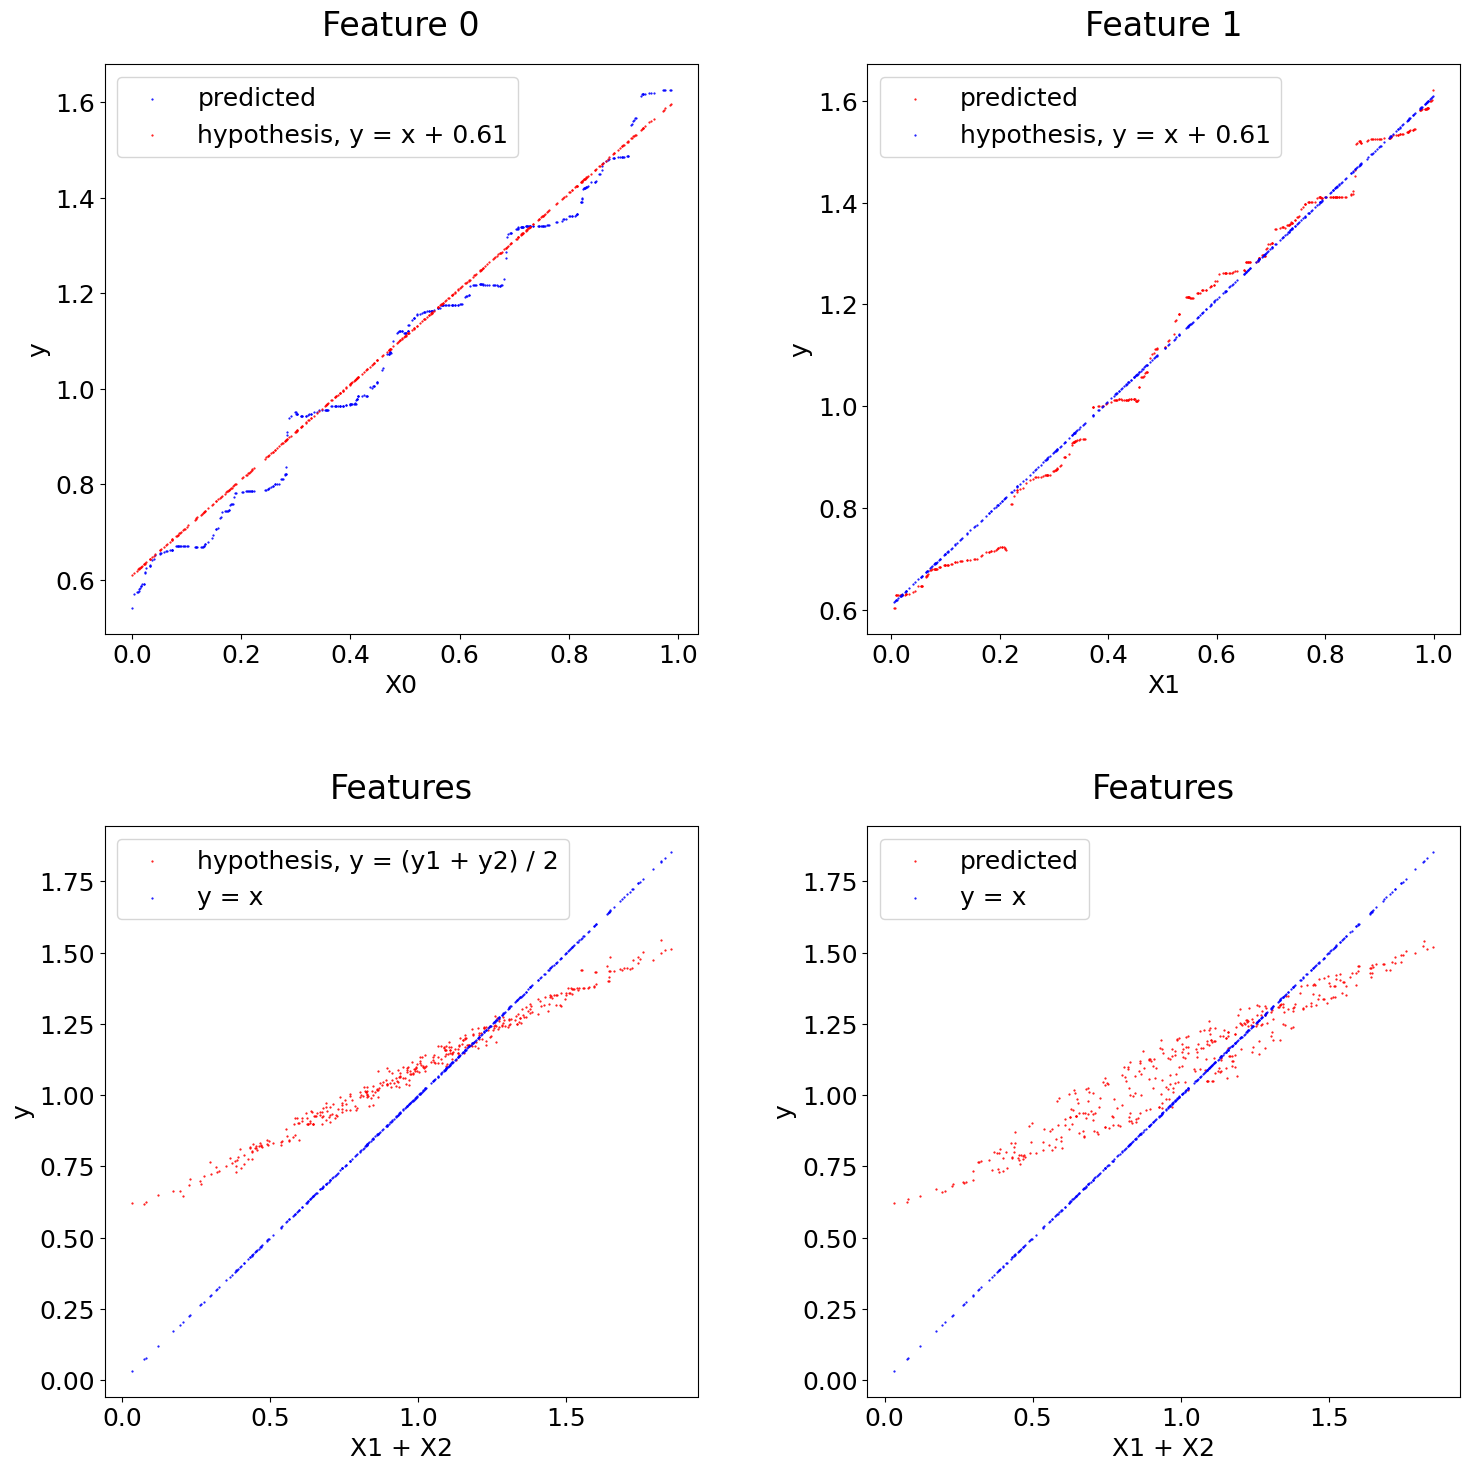

In [ ]:
# rit_alpha = 0.999
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hypothesis_check(arr_1[-1], X_test, y_test)

Деревьев в 0 лесу: 2287, деревьев в 1 лесу: 3713, деревьев в исходном лесу: 6000


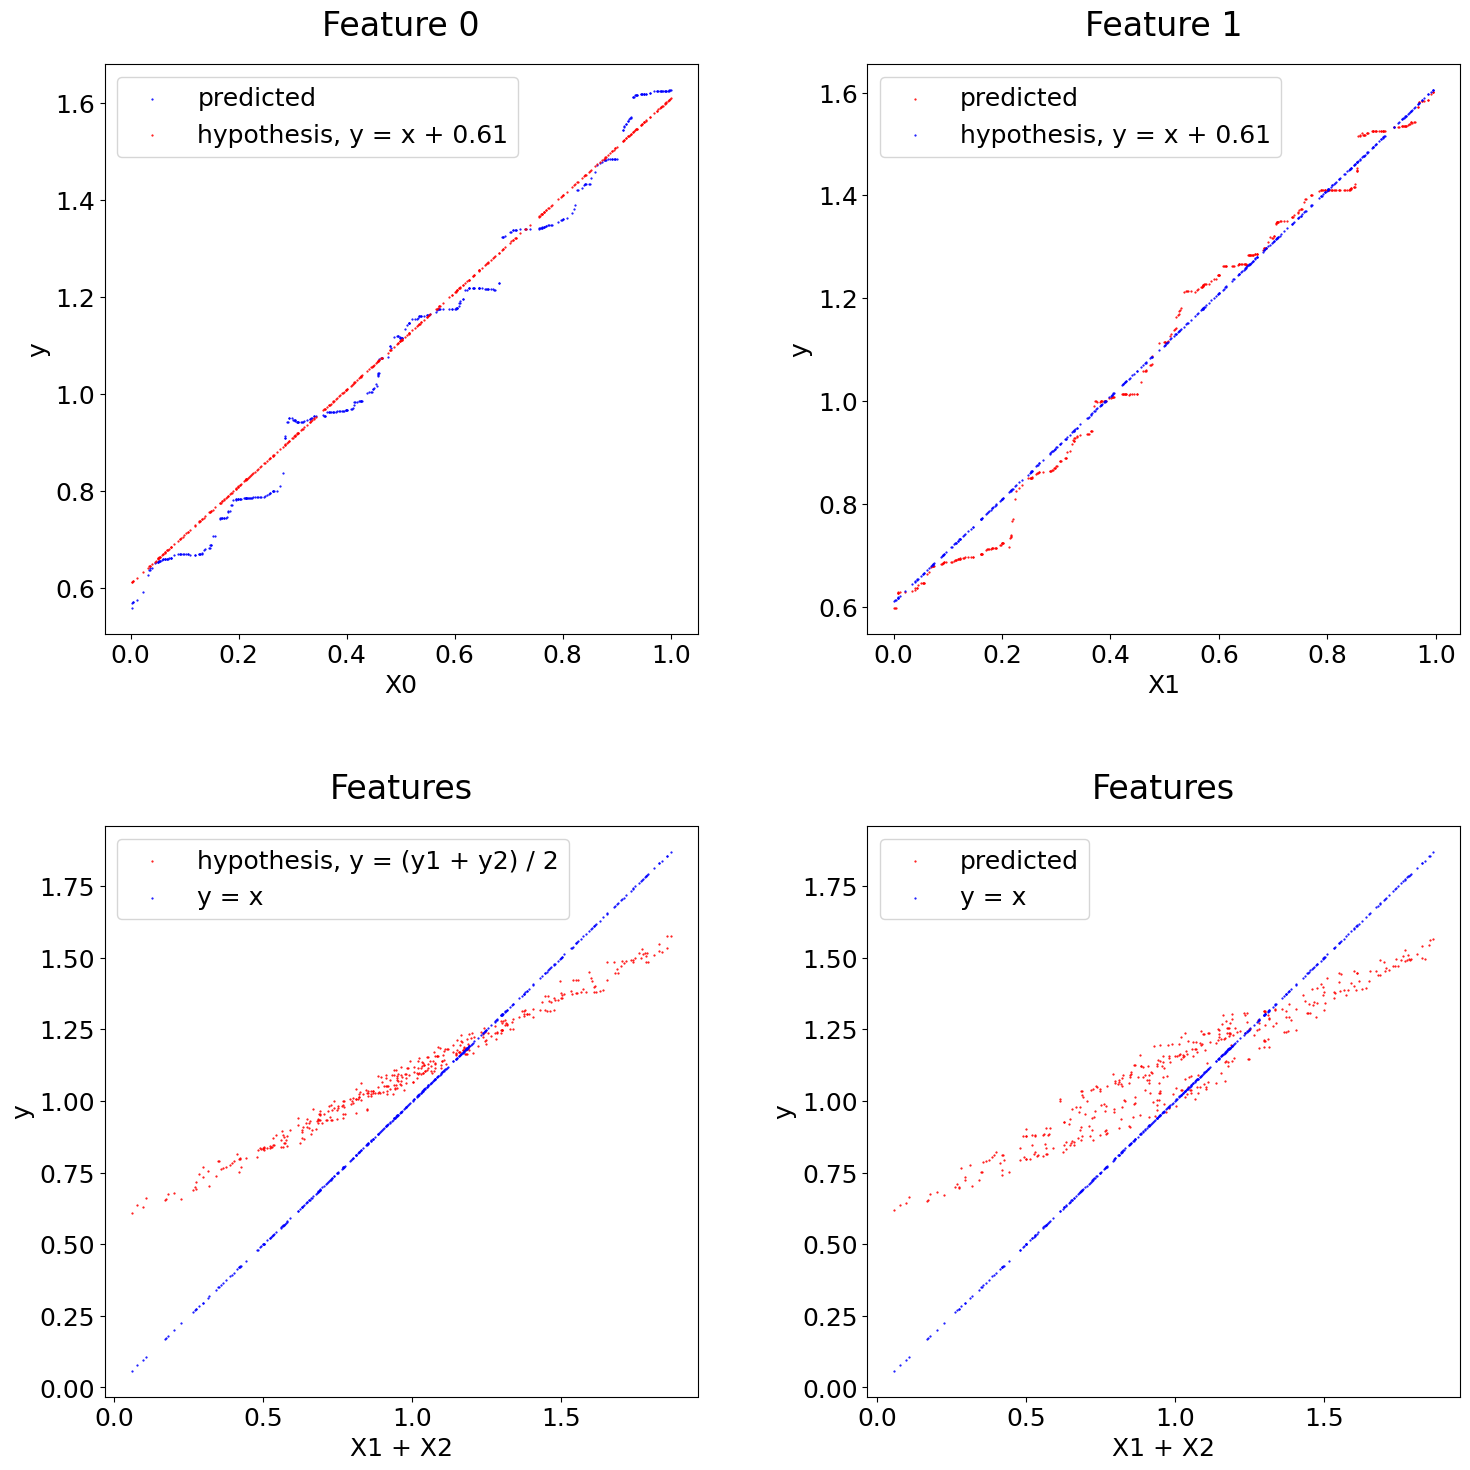

In [51]:
# rit_alpha = 0.995
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hypothesis_check(arr_1[-2], X_test, y_test)

Деревьев в 0 лесу: 2283, деревьев в 1 лесу: 3702, деревьев в исходном лесу: 6000


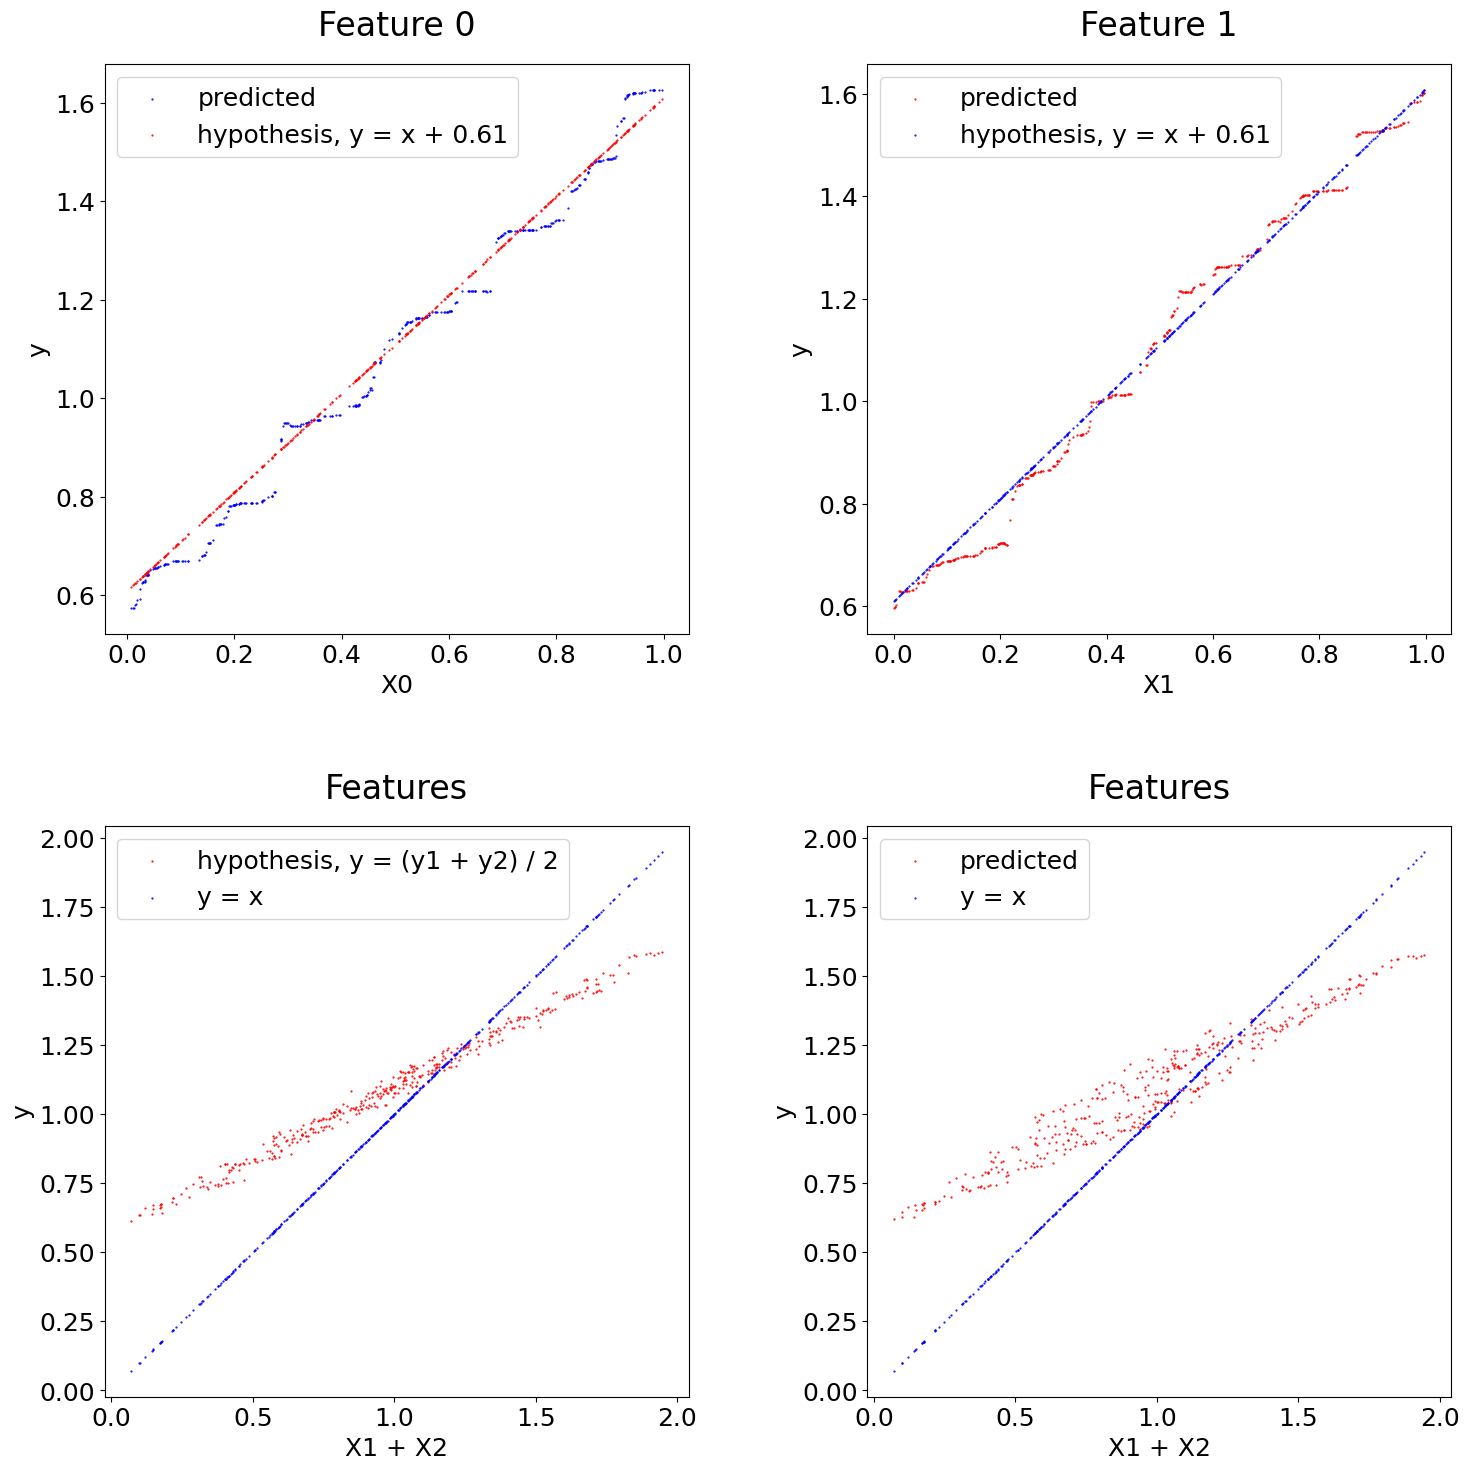

In [52]:
# rit_alpha = 0.99
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hypothesis_check(arr_1[-3], X_test, y_test)

Деревьев в 0 лесу: 282, деревьев в 1 лесу: 455, деревьев в исходном лесу: 6000


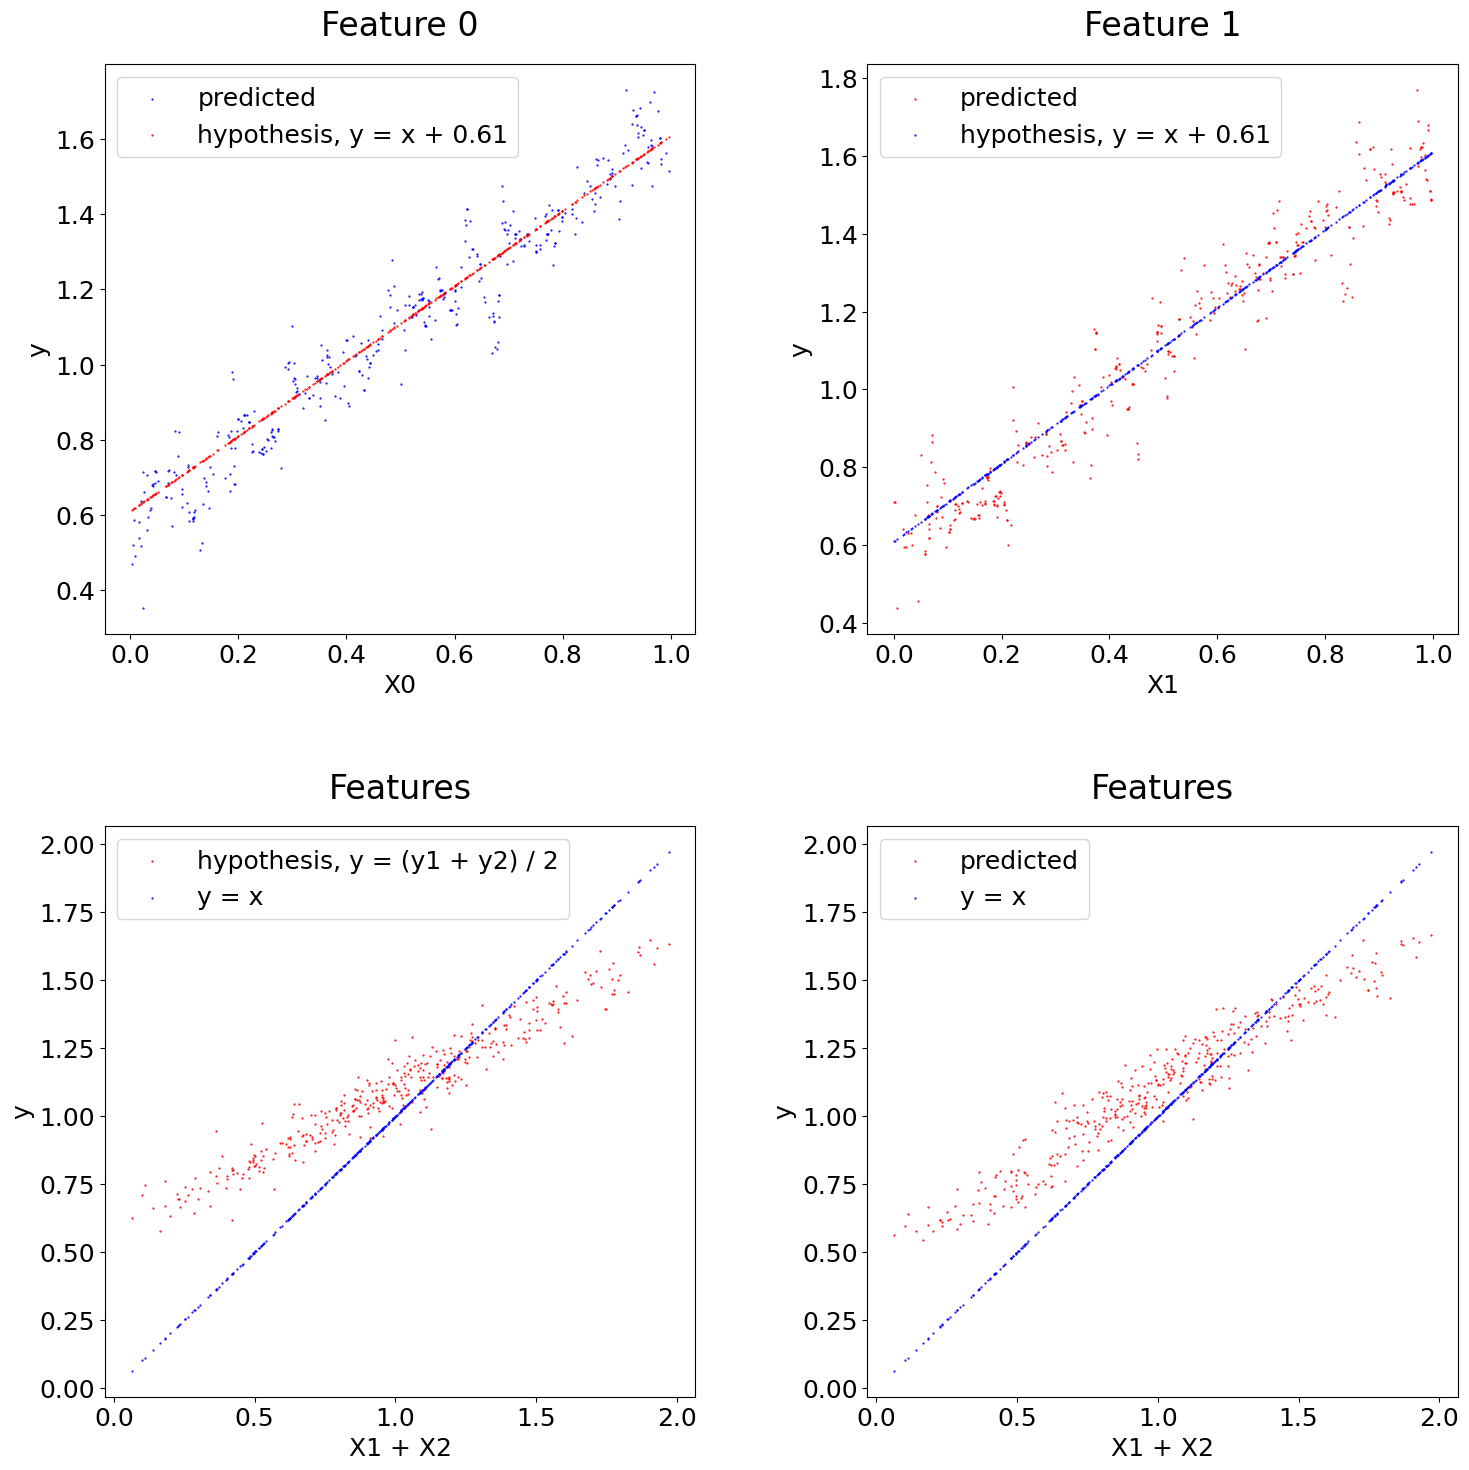

In [54]:
# rit_alpha = 0.98
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hypothesis_check(arr_1[-4], X_test, y_test)

Деревьев в 0 лесу: 2, деревьев в 1 лесу: 1, деревьев в исходном лесу: 6000


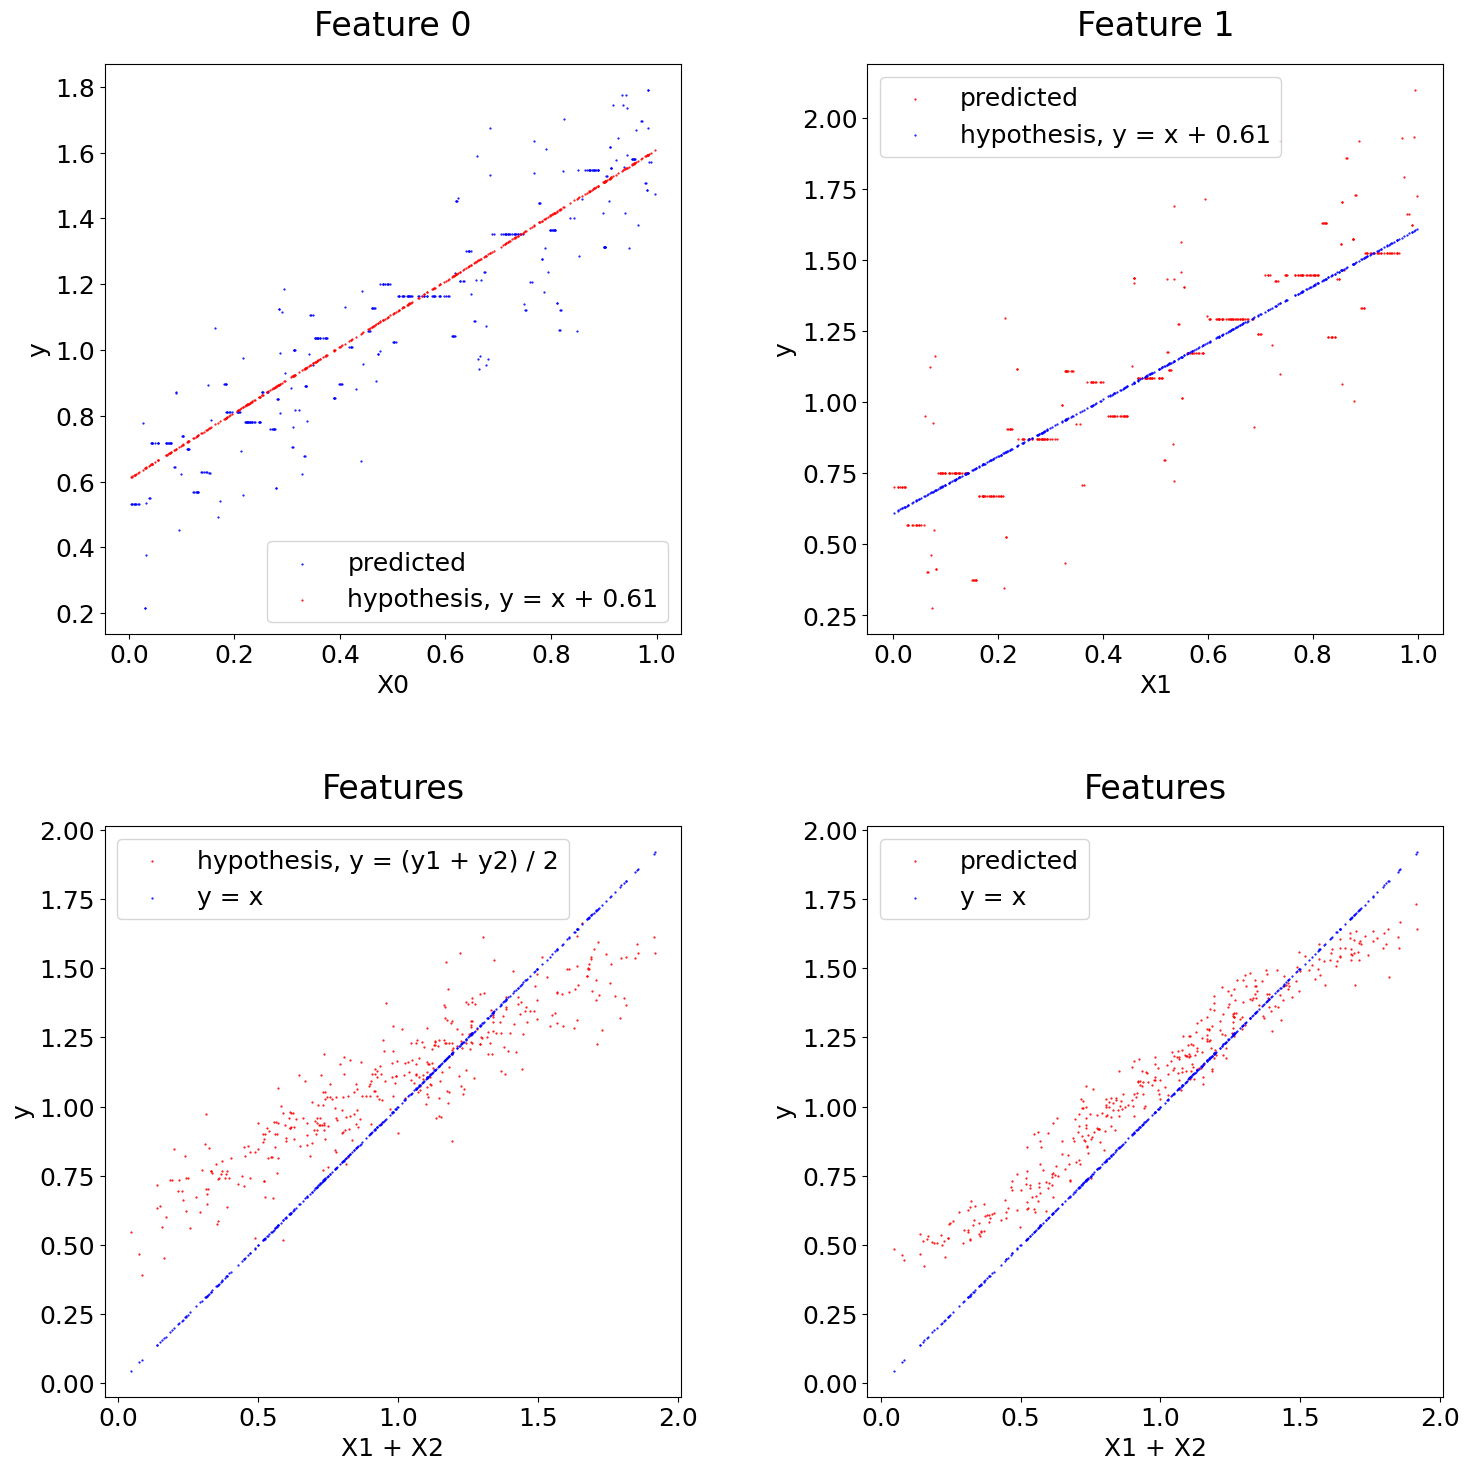

In [55]:
# rit_alpha = 0.97
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hypothesis_check(arr_1[-5], X_test, y_test)

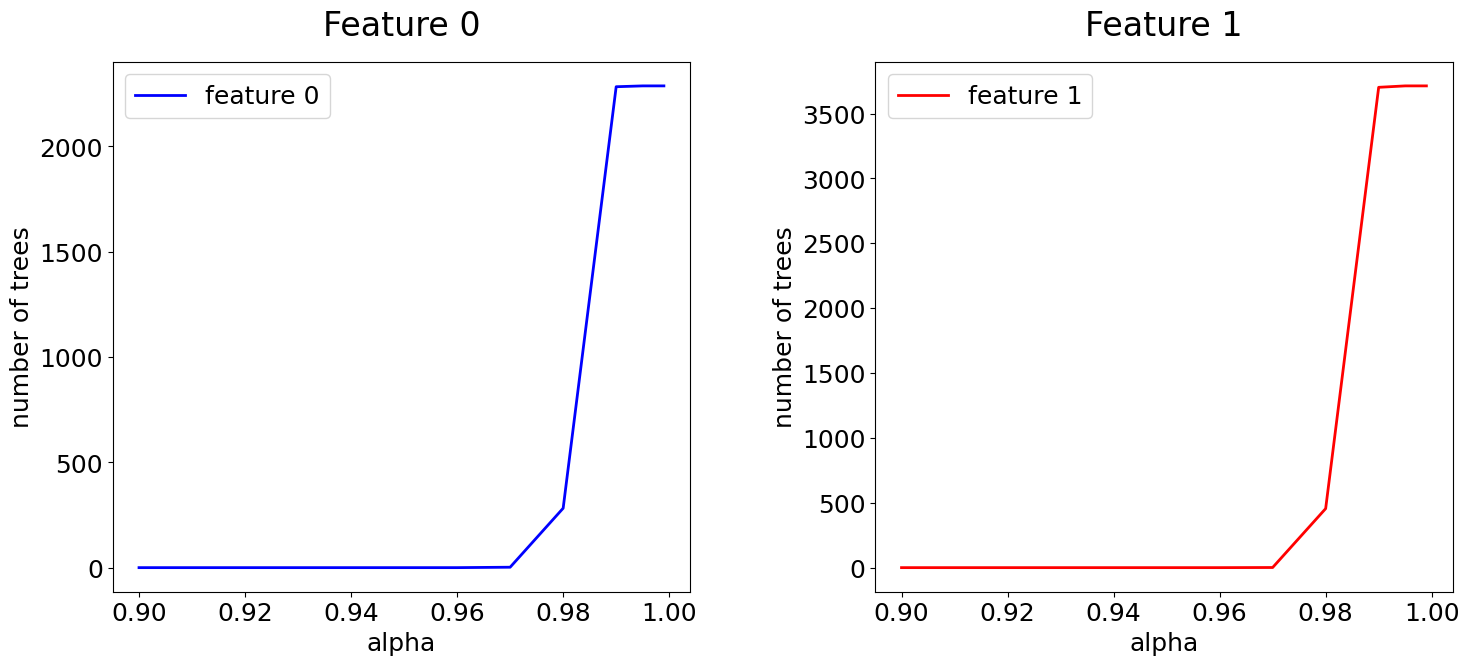

In [44]:
number_of_onecolored_plot(arr_1[1:], alphas[1:-1])

#2 Regression, $Y = X_1 \cdot X_2$

In [ ]:
X, y = data_regression_2D_2()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hypothesis_check(arr_2[-1], X_test, y_test)

#3 Classification, related features

#4 Classification, unrelated features